In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
sns.set_theme()
sns.set_palette("Set2")
palette = sns.color_palette("Set2")

import pycountry
import pycountry_convert as pc

import folium

from datetime import datetime

from src.utils.locationHelper import LocationHelper
from src.utils.preProcessingHelper import PreProcessRatings
import src.utils.preProcessingHelper as preProcessingHelper

from pandas.api.types import CategoricalDtype

import scipy.stats as stats
from scipy.stats import  kruskal, anderson, shapiro
import random

import src.utils.USClimateAndWeatherHelper as WaH
import plotly.express as px
import plotly.graph_objects as go

from src.utils.jeanneHelper import JeanneHelper, get_rating_per_month
helper = JeanneHelper()

np.random.seed(42)

Note: The graphics that we created with plotly won't show on git. We saved all of them in illustrations in the defined folder.

# Preprocessing
### Which data should we use for our investigation?

For the preprocessing we've written a [preProcessingHelper.py](src/utils/preProcessingHelper.py). We have a jupyter notebook [preProcessing.ipynb](test/preProcessing.ipynb) which shows our workflow to eventually get the preProcessingHelper.py


Additionally we've written a [locationHelper.py](src/utils/locationHelper.py), which adds the country and state codes to the reviews. For the part of the analysis that needs a corresponding location to the review, we assume that the location of the user that wrote the review is most likely the location where the review was written. If there is still time after our main tasks, this is something we could investigate further.

In [2]:
df = pd.read_csv("data/beerAdvocateReviewsUSA.csv") # dataset containing reviews and ratings

In [3]:
df.head()

,rating,appearance,aroma,palate,taste,overall,country_name,country_code3,state,date_object,month,year,style
0,2.88,3.25,2.75,3.25,2.75,3.00,United States,USA,Washington,2015-08-20 12:00:00,8,2015,Euro Pale Lager
1,3.67,3.00,3.50,3.50,4.00,3.50,United States,USA,New York,2009-02-20 12:00:00,2,2009,English Pale Ale
2,3.91,4.25,4.50,3.25,3.75,3.75,United States,USA,North Carolina,2013-02-13 12:00:00,2,2013,English Pale Ale
3,3.64,4.00,3.75,3.50,3.50,3.75,United States,USA,New York,2013-01-09 12:00:00,1,2013,English Pale Ale
4,2.77,3.00,3.50,2.50,2.50,2.50,United States,USA,Illinois,2012-11-17 12:00:00,11,2012,English Pale Ale


# 3 Weather Influence by State

## 3.1 climatezone per country / state

### US States

- decide on a states climatezone based on the counties climatezones and weighted by population. In other words: in what climate zones do people in that state live We do this to anaylze in what conditions beer-reviewers live.
County climatezone data from US department for energy: https://www.energy.gov/sites/prod/files/2015/10/f27/ba_climate_region_guide_7.3.pdf
- county population data from: https://www.census.gov/data/tables/time-series/demo/popest/2020s-counties-total.html
- used formatted table from github: https://gist.github.com/philngo/d3e251040569dba67942#file-climate_zones-csv
- state abbreviation list:https://www.faa.gov/air_traffic/publications/atpubs/cnt_html/appendix_a.html


In [4]:
# Define paths
countiesClimate_df_path = "data/climatezones/climate_zones.csv"
countiesPopulation_df_path = "data/climatezones/countyPopulation.xlsx"

# Get the climate data with population
climate_data_with_population = WaH.add_population_to_climate_data(countiesClimate_df_path, countiesPopulation_df_path)

# Get the most populated climate zone for each state
most_populated_climate_zone = WaH.get_most_populated_climate_zone(climate_data_with_population)

#replace 'State' with 'abbreviation'
most_populated_climate_zone = most_populated_climate_zone.rename(columns={'State': 'abbreviation'})

# View the result
most_populated_climate_zone.head()


c:\Users\Work\Documents\GitHub\ada-2024-project-leonardodatavinci\src\utils\USClimateAndWeatherHelper.py:25: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  match = countiesPopulation_df[countiesPopulation_df['County'].str.contains(row['County'], case=False, na=False)]


,abbreviation,IECC Climate Zone,Population
0,AK,7,555076.0
3,AL,3,4377717.0
4,AR,3,3483542.0
6,AS,1,0.0
7,AZ,2,6116085.0


## 3.2 Extracting weather data from excel files

In [5]:
precipitation_df = WaH.extract_data_from_excel('data/weather-data/cru-x0.5_timeseries_pr_timeseries_monthly_1901-2022_mean_historical_cru_ts4.07_mean.xlsx')
temperature_df = WaH.extract_data_from_excel('data/weather-data/cru-x0.5_timeseries_tas_timeseries_monthly_1901-2022_mean_historical_cru_ts4.07_mean.xlsx')

#export to csv
precipitation_df.to_csv('data/weather-data/us-precipitations.csv', index=False)
temperature_df.to_csv('data/weather-data/us-temperatures.csv', index=False)

precipitation_df

,code,state,value,year,month
0,USA,United States of America,46.10,1901,1
1,USA.2593214,Alabama,116.85,1901,1
2,USA.2593215,Alaska,35.22,1901,1
3,USA.2593216,Arizona,24.17,1901,1
4,USA.2593217,Arkansas,60.62,1901,1
...,...,...,...,...,...
76123,USA.2593260,Virginia,96.01,2022,12
76124,USA.2593261,Washington,169.15,2022,12
76125,USA.2593262,West Virginia,82.01,2022,12
76126,USA.2593263,Wisconsin,50.55,2022,12


In [6]:
# Compute oldest and newest year
oldest_year = min(precipitation_df['year'].min(), temperature_df['year'].min())
newest_year = max(precipitation_df['year'].max(), temperature_df['year'].max())

# Print the oldest and newest year
print(f"Oldest year: {oldest_year}")
print(f"Newest year: {newest_year}")


Oldest year: 1901
Newest year: 2022


In [7]:
month = 1
year = 1986
state = "United States of America"

precipitation_USA_1986_1 = WaH.value_from_date_and_state(precipitation_df, year, month, state)
print(f"Precipitation in {state} in {month}-{year}: {precipitation_USA_1986_1}")

Precipitation in United States of America in 1-1986: 36.83


In [8]:
beer_data = df 

In [9]:
# Filter for US only
beer_data_with_weather = beer_data[beer_data["country_name"] == "United States"]

#Filter for years between 2002 and 2017
beer_data_with_weather = beer_data_with_weather[(beer_data_with_weather["year"] >= 2002) & (beer_data_with_weather["year"] <= 2017)]

# print shape
print("original shape: ", beer_data.shape)
print("new shape: ", beer_data_with_weather.shape)

# beer_data_with_weather = beer_data_with_weather.head(1000)

beer_data_with_weather = WaH.apply_value_from_date_and_state(beer_data_with_weather,precipitation_df, "Precipitation")
beer_data_with_weather = WaH.apply_value_from_date_and_state(beer_data_with_weather,temperature_df, "Temperature")
beer_data_with_weather = preProcessingHelper.merge_with_states(beer_data_with_weather)

# merge most_populated_climate_zone with df
beer_data_with_weather = beer_data_with_weather.merge(most_populated_climate_zone, how='left', on='abbreviation')

beer_data_with_weather.head()



original shape:  (2240430, 13)
new shape:  (2239823, 13)


,rating,appearance,aroma,palate,taste,overall,country_name,country_code3,state,date_object,month,year,style,Precipitation,Temperature,abbreviation,IECC Climate Zone,Population
0,2.88,3.25,2.75,3.25,2.75,3.00,United States,USA,Washington,2015-08-20 12:00:00,8,2015,Euro Pale Lager,40.63,19.08,WA,4,2658093.0
1,3.67,3.00,3.50,3.50,4.00,3.50,United States,USA,New York,2009-02-20 12:00:00,2,2009,English Pale Ale,43.11,-4.40,NY,5,7878123.0
2,3.91,4.25,4.50,3.25,3.75,3.75,United States,USA,North Carolina,2013-02-13 12:00:00,2,2013,English Pale Ale,108.89,5.84,NC,4,8582452.0
3,3.64,4.00,3.75,3.50,3.50,3.75,United States,USA,New York,2013-01-09 12:00:00,1,2013,English Pale Ale,56.13,-4.27,NY,5,7878123.0
4,2.77,3.00,3.50,2.50,2.50,2.50,United States,USA,Illinois,2012-11-17 12:00:00,11,2012,English Pale Ale,29.50,5.59,IL,5,6671604.0


## 3.3 Data Analysis

## Timeline and number of reviews

In [10]:
# Create a 'date' column for easier grouping
beer_data_with_weather['date'] = pd.to_datetime(beer_data_with_weather[['year', 'month']].assign(day=1))

# 1. Plot month/year vs. number of rows using Plotly

# Count the number of rows per unique date
row_counts = beer_data_with_weather['date'].value_counts().sort_index()

# Create a line plot using Plotly Express
fig = px.line(
    x=row_counts.index,
    y=row_counts.values,
    labels={'x': 'Date', 'y': 'Number of Rows'},
    title='Number of Rows per Month/Year'
)

# Update layout for better appearance
fig.update_layout(
    xaxis=dict(
        tickformat='%Y-%m',
        tickangle=45
    ),
    xaxis_tickformatstops=[
        dict(dtickrange=[None, None], value="%Y-%m")
    ]
)

#Save the plot
fig.write_html("illustrations/Nicolas/number_of_rows_per_month_year.html")

# 2. Plot a timeline with start month/year and end month/year using Plotly

# Get the start and end dates
start_date = beer_data_with_weather['date'].min()
end_date = beer_data_with_weather['date'].max()

# Create a figure
fig_timeline = go.Figure()

# Add a line and markers to represent the timeline
fig_timeline.add_trace(go.Scatter(
    x=[start_date, end_date],
    y=[0, 0],
    mode='lines+markers',
    marker=dict(size=10),
    line=dict(width=2),
    showlegend=False
))

# Update layout for the timeline
fig_timeline.update_layout(
    title=f'Timeline of Dataset<br><sup>Start: {start_date.strftime("%Y-%m")} | End: {end_date.strftime("%Y-%m")}</sup>',
    xaxis_title='Date',
    yaxis=dict(
        showticklabels=False,
        showgrid=False,
        zeroline=False
    ),
    xaxis=dict(
        tickformat='%Y-%m',
        tickangle=45
    ),
    height=200,
    margin=dict(l=50, r=50, t=80, b=50)
)


#Save the plot
fig_timeline.write_html("illustrations/Nicolas/timeline.html")

## Descriptive Statistics for Weather Data

In [11]:
# Descriptive statistics for weather data
weather_stats = beer_data_with_weather[['Temperature', 'Precipitation']].describe()
print("Descriptive Statistics for Weather Data:")
print(weather_stats)


Descriptive Statistics for Weather Data:
        Temperature  Precipitation
count  2.239823e+06   2.239823e+06
mean   1.151837e+01   8.522982e+01
std    9.671731e+00   4.805576e+01
min   -2.649000e+01   2.600000e-01
25%    4.140000e+00   5.105000e+01
50%    1.202000e+01   8.198000e+01
75%    1.973000e+01   1.143600e+02
max    3.123000e+01   4.664700e+02


## Average Temperature

In [12]:
# Average temperature per month for each state
avg_temp_state = beer_data_with_weather.groupby(['state', 'month'])['Temperature'].mean().reset_index()

# Plot
fig = px.line(avg_temp_state, x='month', y='Temperature', color='state', 
              title="Average Monthly Temperature by State",
              labels={'Temperature': 'Avg Temperature (°C)', 'month': 'Month', 'state': 'State'})
fig.update_layout(xaxis=dict(tickmode='array', tickvals=list(range(1, 13)), ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']))

#save
fig.write_html("illustrations/Nicolas/avg_temp_state.html")


In [13]:
# Calculate average temperature by state and month
temp_heatmap = beer_data_with_weather.groupby(['state', 'month'])['Temperature'].mean().reset_index()

# Create heatmap with inverted axes (months on y-axis, states on x-axis)
fig = px.imshow(temp_heatmap.pivot(index='month', columns='state', values='Temperature'),
                labels=dict(x="State", y="Month", color="Avg Temperature (°C)"),
                y=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                title="Average Temperature by Month and State")


# Save plot
fig.write_html("illustrations/Nicolas/heatmap.html")

In [14]:
# Calculate the average temperature by state abbreviation
state_monthly_avg_temp = beer_data_with_weather.groupby(['abbreviation', 'month'])['Temperature'].mean().reset_index()

state_monthly_avg_temp = preProcessingHelper.merge_with_abbreviations(state_monthly_avg_temp)

state_monthly_avg_temp.head()

,abbreviation,month,Temperature,state
0,AK,1,-17.886830,Alaska
1,AK,2,-15.535399,Alaska
2,AK,3,-12.840988,Alaska
3,AK,4,-4.540952,Alaska
4,AK,5,3.844366,Alaska


In [15]:
# Define fixed color scale range
min_temp = state_monthly_avg_temp['Temperature'].min()  # e.g., -35
max_temp = state_monthly_avg_temp['Temperature'].max()  # e.g., 30

# Create the timelapse choropleth map
fig = px.choropleth(
    state_monthly_avg_temp,
    locations='abbreviation',           # Column with state abbreviations
    locationmode='USA-states',           # Specifies that locations are USA states
    color='Temperature',                 # Data to color the states by
    hover_name='state',                  # Display full state name on hover
    scope='usa',                         # Focuses the map on the USA
    color_continuous_scale='Viridis',    # Color scale
    labels={'Temperature': 'Avg Temperature (°C)', 'month': 'Month'},
    title='Average Temperature by State in the USA Over Time',
    animation_frame='month',             # Create animation based on the month
    range_color=[min_temp, max_temp]     # Set fixed scale for the color range
)

# Customize animation speed
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 500  # Adjust speed (milliseconds per frame)
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 300

# Save Timelapse
fig.write_html("illustrations/Nicolas/timelapse_temperature.html")


## Climate Zones

In [16]:
# Map of IECC Climate Zones

fig = px.choropleth(most_populated_climate_zone, locations='abbreviation', locationmode='USA-states', color='IECC Climate Zone', 
                    hover_name='abbreviation', scope='usa', color_discrete_sequence=px.colors.sequential.Plasma_r, 
                    title='IECC Climate Zones in the USA')

fig.write_html("illustrations/Nicolas/climate_zones.html")

## Precipitations

In [17]:
# Average precipitation per month for each state
avg_precip_state = beer_data_with_weather.groupby(['state', 'month'])['Precipitation'].mean().reset_index()

# Plot
fig = px.line(avg_precip_state, x='month', y='Precipitation', color='state', 
              title="Average Monthly Precipitation by State",
              labels={'Precipitation': 'Avg Precipitation (mm)', 'month': 'Month', 'state': 'State'})
fig.update_layout(xaxis=dict(tickmode='array', tickvals=list(range(1, 13)), ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']))

fig.write_html("illustrations/Nicolas/precipitation.html")

## Combined Metrics

In [18]:
# Calculate the average temperature by state
state_temp = beer_data_with_weather.groupby(['abbreviation'])['Temperature'].mean().reset_index()

#Calculate the average precipitation by state
state_precip = beer_data_with_weather.groupby(['abbreviation'])['Precipitation'].mean().reset_index()

#extract climate zones
state_climate_zone = most_populated_climate_zone[['abbreviation', 'IECC Climate Zone']]

# Merge the dataframes
state_weather = pd.merge(state_temp, state_precip, on='abbreviation')
state_weather = pd.merge(state_weather, state_climate_zone, on='abbreviation')

state_weather = preProcessingHelper.merge_with_abbreviations(state_weather)

state_weather.head()

,abbreviation,Temperature,Precipitation,IECC Climate Zone,state
0,AK,-5.983656,44.160920,7,Alaska
1,AL,17.964573,116.981815,3,Alabama
2,AR,16.657295,109.090646,3,Arkansas
3,AZ,15.891391,23.270039,2,Arizona
4,CA,14.428512,42.936489,3,California


In [19]:
# Create a mapping of state abbreviations to numerical values
state_mapping = {state: i for i, state in enumerate(state_weather['state'].unique())}
state_weather['state_num'] = state_weather['state'].map(state_mapping)

# Create the parallel coordinates plot
fig = go.Figure(data=go.Parcoords(
    line=dict(color=state_weather['Temperature'],
              showscale=True,
              cmin=state_weather['Temperature'].min(),
              cmax=state_weather['Temperature'].max()),
    dimensions=[
        dict(
            range=[min(state_mapping.values()), max(state_mapping.values())],
            label='State',
            values=state_weather['state_num'],
            tickvals=list(state_mapping.values()),
            ticktext=list(state_mapping.keys())
        ),
        dict(
            range=[state_weather['Temperature'].min(), state_weather['Temperature'].max()],
            label='Avg Temperature (°C)',
            values=state_weather['Temperature']
        ),
        dict(
            range=[state_weather['Precipitation'].min(), state_weather['Precipitation'].max()],
            label='Avg Precipitation (mm)',
            values=state_weather['Precipitation']
        ),
        dict(
            range=[state_weather['IECC Climate Zone'].min(), state_weather['IECC Climate Zone'].max()],
            label='Climate Zone',
            values=state_weather['IECC Climate Zone']
        )
    ]
))

# Update layout
fig.update_layout(
    title='Parallel Coordinates Plot of State Weather Data',
    plot_bgcolor='white',
    paper_bgcolor='white'
)

# Save the plot as an HTML file
fig.write_html("illustrations/Nicolas/Weather_overview.html")


## Correlation Analysis Between Weather and Beer Ratings

In [20]:
beer_data_with_weather.columns

Index(['rating', 'appearance', 'aroma', 'palate', 'taste', 'overall',
       'country_name', 'country_code3', 'state', 'date_object', 'month',
       'year', 'style', 'Precipitation', 'Temperature', 'abbreviation',
       'IECC Climate Zone', 'Population', 'date'],
      dtype='object')

In [21]:
# Calculate correlation matrix for weather and ratings
correlation_matrix = beer_data_with_weather[['rating', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'Temperature', 'Precipitation','IECC Climate Zone']].corr()

# Visualize correlation using a heatmap with Plotly
import plotly.figure_factory as ff

fig = ff.create_annotated_heatmap(
    z=correlation_matrix.values,
    x=correlation_matrix.columns.tolist(),
    y=correlation_matrix.index.tolist(),
    colorscale='Viridis',
    showscale=True
)
fig.update_layout(title_text="Correlation Heatmap: Ratings and Weather")
fig.write_html("illustrations/Nicolas/correlation_heatmap.html")
fig.show()


In [22]:
# Filter numeric columns
numeric_columns = beer_data_with_weather.select_dtypes(include='number').columns

# Include the 'state' column for grouping
state_level_data = beer_data_with_weather.groupby('state')[numeric_columns].mean().reset_index()

# Select relevant columns for correlation analysis
columns_to_analyze = ['rating', 'Temperature', 'Precipitation']
state_correlation_matrix = state_level_data[columns_to_analyze].corr()


In [23]:
import plotly.figure_factory as ff

# Create a correlation matrix heatmap
corr_matrix = state_level_data[['rating', 'Temperature', 'Precipitation']].corr()
fig = ff.create_annotated_heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns.tolist(),
    y=corr_matrix.index.tolist(),
    colorscale='Viridis',
    showscale=True,
    hoverinfo="z"
)
fig.update_layout(title='Correlation Matrix Heatmap', xaxis_title="Variables", yaxis_title="Variables")
fig.show()


In [24]:
# Filter numeric columns
numeric_columns = beer_data_with_weather.select_dtypes(include='number').columns

# Include the 'state' column for grouping
state_level_data = beer_data_with_weather.groupby('state')[numeric_columns].mean().reset_index()

In [25]:
# Create a correlation matrix heatmap
corr_matrix = state_level_data[['rating', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'Temperature', 'Precipitation','IECC Climate Zone']].corr()
fig = ff.create_annotated_heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns.tolist(),
    y=corr_matrix.index.tolist(),
    colorscale='Viridis',
    showscale=True,
    hoverinfo="z"
)
fig.update_layout(title='Correlation Matrix Heatmap', xaxis_title="Variables", yaxis_title="Variables")
fig.show()

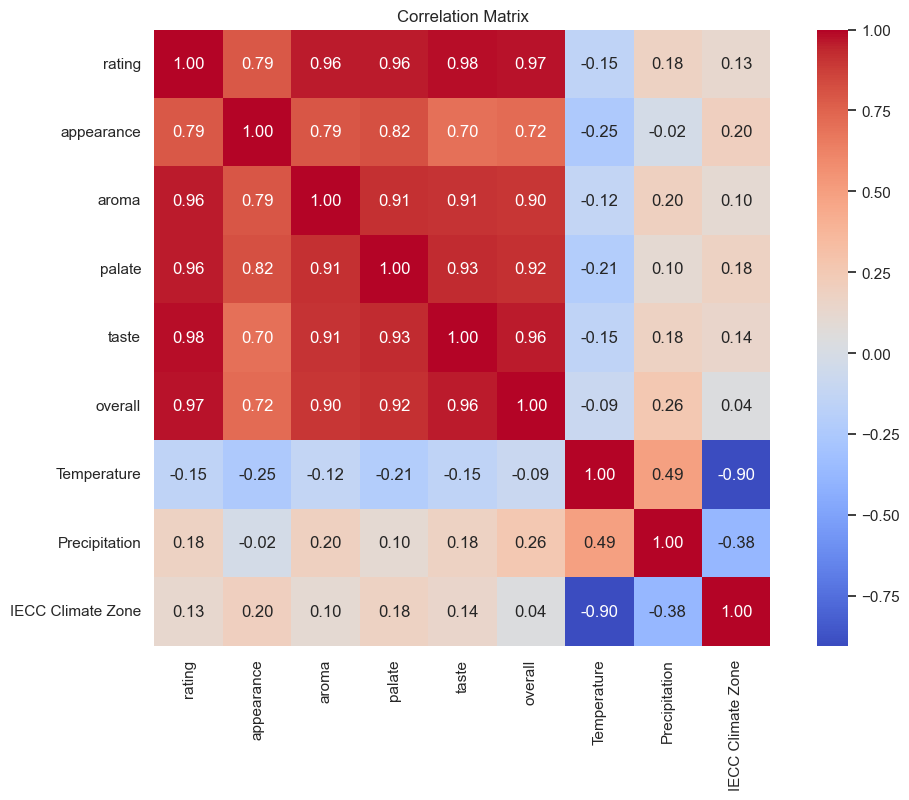

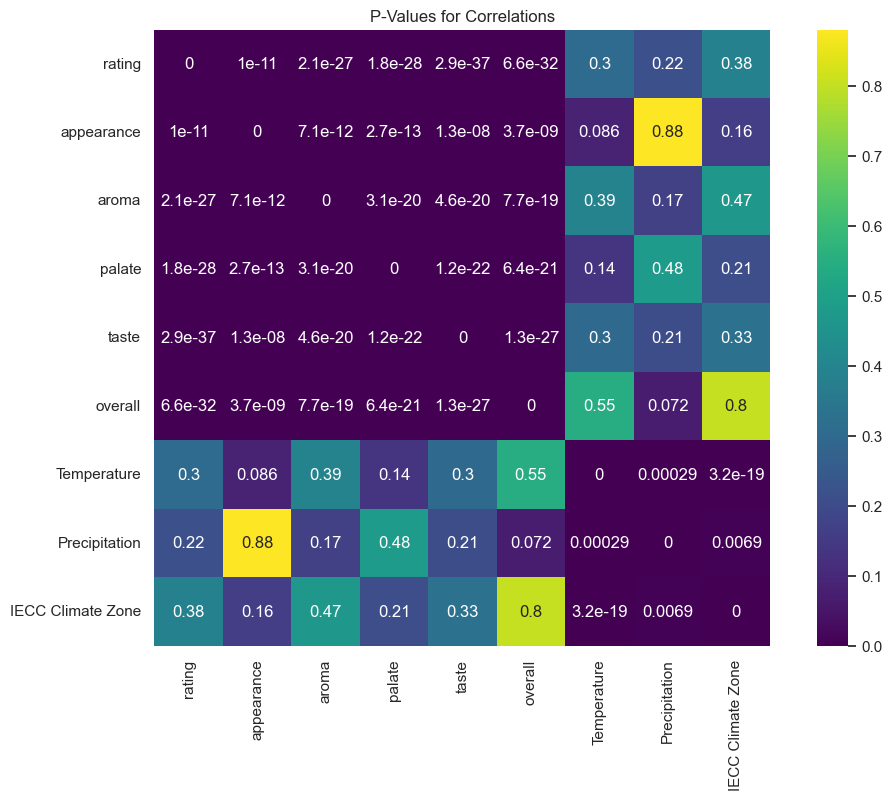

ANOVA Results for Ratings by IECC Climate Zone:
F-statistic: 0.5351092324767154
p-value: 0.7785064896825895


In [26]:
# Function to calculate statistical significance for correlation coefficients
def calculate_p_values(df):
    df = df.dropna()
    p_values = pd.DataFrame(np.zeros((df.shape[1], df.shape[1])), columns=df.columns, index=df.columns)
    for col1 in df.columns:
        for col2 in df.columns:
            _, p_value = stats.pearsonr(df[col1], df[col2])
            p_values.loc[col1, col2] = p_value
    return p_values

# Calculate correlation matrix
correlation_matrix = state_level_data[['rating', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'Temperature', 'Precipitation','IECC Climate Zone']].corr()

# Calculate p-values for correlations
p_values = calculate_p_values(state_level_data[['rating', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'Temperature', 'Precipitation','IECC Climate Zone']])

# Display heatmap for correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Correlation Matrix")
plt.show()

# Display heatmap for p-values
plt.figure(figsize=(12, 8))
sns.heatmap(p_values, annot=True, fmt=".2g", cmap="viridis", cbar=True, square=True)
plt.title("P-Values for Correlations")
plt.show()

# ANOVA to test differences in ratings by IECC Climate Zone
anova_result = stats.f_oneway(
    *(state_level_data[state_level_data['IECC Climate Zone'] == zone]['rating'] for zone in state_level_data['IECC Climate Zone'].unique())
)
print("ANOVA Results for Ratings by IECC Climate Zone:")
print("F-statistic:", anova_result.statistic)
print("p-value:", anova_result.pvalue)


### Interpretation of Results

#### Correlation Matrix

1. **High Correlations Between Rating Metrics**:
   - As expected metrics such as `rating`, `appearance`, `aroma`, `palate`, `taste`, and `overall` are strongly correlated with one another, since the sub-metrics are used to compute the `overall` score.

2. **Weak Correlations with Weather Variables**:
   - `Temperature` shows a weak negative correlation with `rating` (-0.15), while `Precipitation` has a weak positive correlation (0.18).
   - `IECC Climate Zone` exhibits very weak or negligible correlations with the beer rating metrics, suggesting minimal direct influence.


#### P-Values for Correlations

1. **Statistically Significant Beer Rating Metrics**:
   - Correlations among `rating`, `appearance`, `aroma`, `palate`, `taste`, and `overall` have p-values close to zero, confirming that these correlations are statistically significant.

2. **Non-Significant Weather-Rating Correlations**:
   - The correlations of weather variables (`Temperature`, `Precipitation`, and `IECC Climate Zone`) with beer rating metrics are not statistically significant (p-values > 0.05).
   - This indicates insufficient evidence to conclude that these weather factors influence beer ratings.


#### ANOVA Results for Ratings by IECC Climate Zone

- The ANOVA test produced a **F-statistic of 0.535** and a **p-value of 0.779**, indicating that the differences in beer ratings across IECC Climate Zones are not statistically significant.
- This suggests that beer ratings are relatively consistent regardless of the climate zone, further supporting the weak correlations observed between weather factors and beer ratings.

### Summary

The analysis reveals that:
1. Beer rating metrics are highly interdependent and provide consistent assessments of beer quality.
2. Weather variables such as temperature, precipitation, and IECC Climate Zone do not significantly influence beer ratings.
3. Climatic differences across IECC zones do not explain variations in beer ratings.

These results suggest that weather factors may have little to no direct effect on beer ratings, highlighting the importance of focusing on other potential factors such as consumer preferences, cultural influences, or regional beer styles.

## Mutual Information (MI) between variables

In [29]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_regression
from sklearn.utils import shuffle

# 'rating' is the target variable, and ['Temperature', 'Precipitation'] are the features

# Extract features and target
X = beer_data_with_weather[['Temperature', 'Precipitation']]
y = beer_data_with_weather['rating']

# Calculate Mutual Information
mi = mutual_info_regression(X, y, random_state=0)
mi_results = pd.Series(mi, index=X.columns)

# Display MI results
print("Mutual Information between weather variables and beer ratings:")
print(mi_results)

# Permutation Test to assess significance
n_permutations = 1000
mi_permuted = np.zeros((n_permutations, len(X.columns)))

for i in range(n_permutations):
    y_permuted = shuffle(y, random_state=i)
    mi_permuted[i, :] = mutual_info_regression(X, y_permuted, random_state=0)

# Calculate p-values
p_values = (np.sum(mi_permuted >= mi, axis=0) + 1) / (n_permutations + 1)
p_value_results = pd.Series(p_values, index=X.columns)

# Display p-values
print("\nP-values for the Mutual Information estimates:")
print(p_value_results)


Mutual Information between weather variables and beer ratings:
Temperature      0.058512
Precipitation    0.082730
dtype: float64


KeyboardInterrupt: 

## Decision Tree Model

Mean Squared Error: 0.3422232578177394
R-squared: 0.023718219977467148


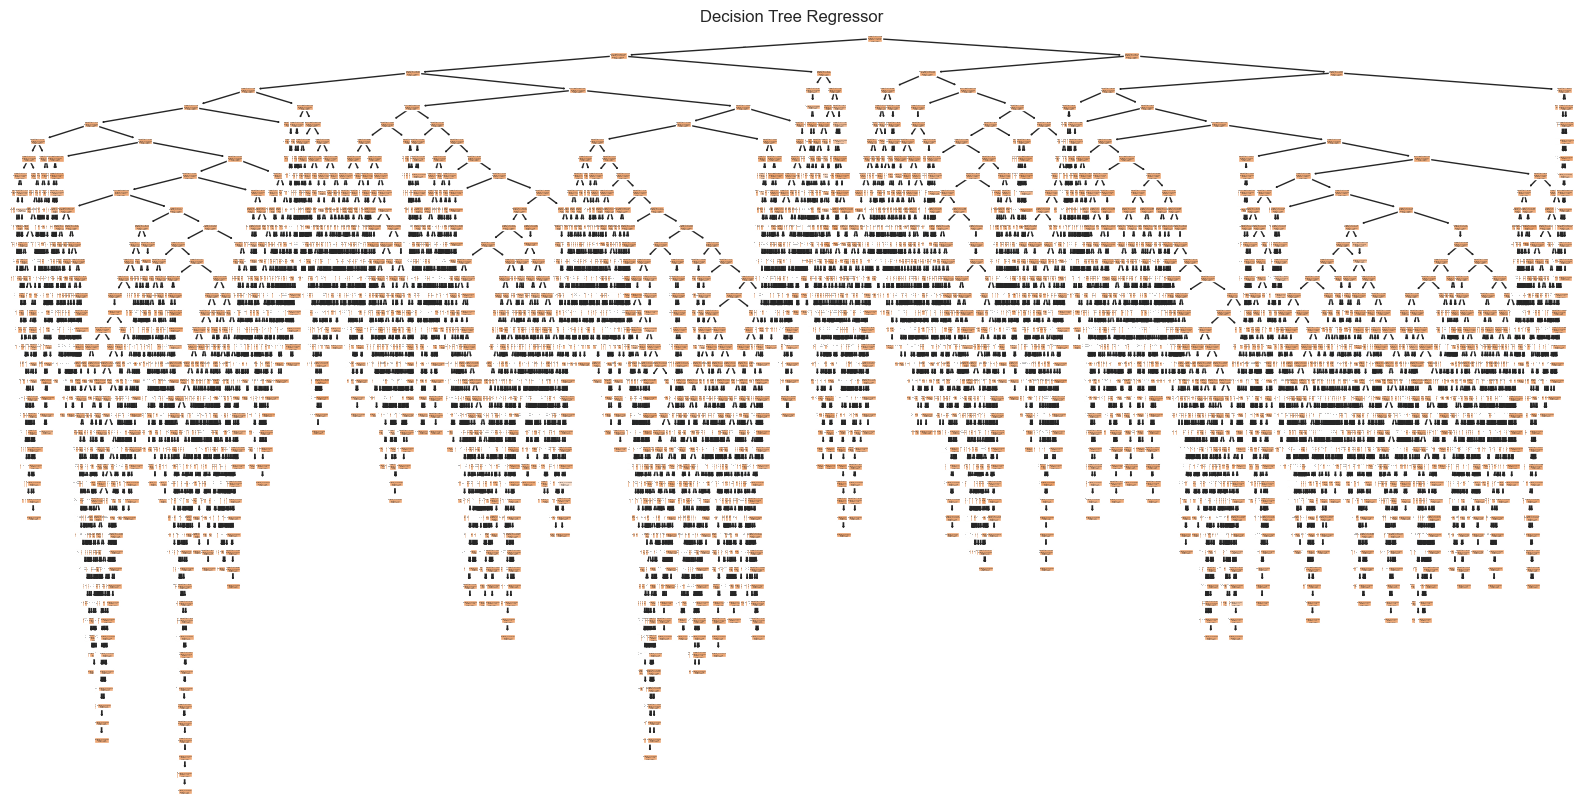

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


# Define features and target variable
# Replace 'rating' with your target variable and include relevant weather features
features = ['Temperature', 'Precipitation', 'IECC Climate Zone']
target = 'rating'

X = beer_data_with_weather[features]
y = beer_data_with_weather[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Decision Tree Regressor
regressor = DecisionTreeRegressor(random_state=42)

# Train the model
regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Visualize the Decision Tree
plt.figure(figsize=(20,10))
plot_tree(regressor, feature_names=features, filled=True)
plt.title('Decision Tree Regressor')
plt.show()
